---
layout: code-post
title: How does training work?
tags: [neural nets]
---

Now that we've established a training regime that works on simple problems,
let's investigate how the parameters evolve during training. The questions
I'd like to answer are:

- What is the distribution of coefficient change?
    - What is max coefficient change?
    - What is the average coefficent change?
    - How often do coefficients change sign?
    - Correlation between sign (direction of) change and amount of change?
    - What happens first, getting larger or going to zero?
- Do the above questions depend on the layer?
- How effective is the lottery ticket hypothesis?
    - Removing without retraining?
    - Removing with retraining from same initial weights?
    
to start looking into these questions (without claiming to provide answers)
I'm going to start with one training set and one architecture but train it 
from many initial conditions to see what happens.

Outline:
1. Setup
    - Training Data
    - Neural Net
    - Visualization Code
2. Coefficient changes
3. Layer dependence
4. Lottery Ticket Hypothesis

## Setup

We start by recycling code from the [initialization notebook](https://kevinnowland.com/code/2020/05/16/initialization.html)
to set up the training data and the neural net.

### Training data

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import copy

In [96]:
def normalize_data(df, col_names=['x_1', 'x_2']):
    """ return normalized x_1 and x_2 columns """
    return (df[col_names] - df[col_names].mean()) / df[col_names].std()

def train_data(random_seed=3):

    np.random.seed(random_seed)
    
    def rad_sq(array):
        return array[:, 0]**2 + array[:, 1]**2

    data_pos_ = np.random.normal(0, .75, size=(100, 2))
    data_pos = data_pos_[rad_sq(data_pos_) < 4]

    data_neg_ = np.random.uniform(-5, 5, size=(1000, 2))
    data_neg = data_neg_[(rad_sq(data_neg_) > 6.25) & (rad_sq(data_neg_) < 16)]

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)

    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'const': 1.0
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df

We'll plot the training data to see what we're working with here.

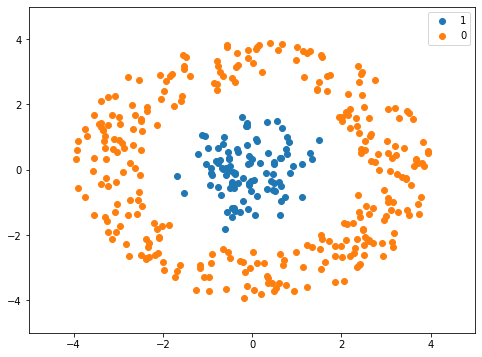

In [97]:
df_train = train_data()

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

c = df_train['y'] == 1
ax.scatter(df_train[c]['x_1'], df_train[c]['x_2'], marker='o', color='C0', label='1')
ax.scatter(df_train[~c]['x_1'], df_train[~c]['x_2'], marker='o', color='C1', label='0')
ax.legend()

plt.show()

### Neural net

We will be using a neural net with `ReLU` activation functions and biases
in the hidden layers and the sigmoid function as the output layer. The
initialization will be done using Kaiming He's initiliazation.

In [110]:
class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])

class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, 
                 init='Xavier', random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        def init_weights(i, init):
            """ init weights with either Xavier or Kaiming He initialization 
            If there are biases in this layer, they are initialized to something small"""
            
            if self._layers[i].has_const:
                ncols = self._layers[i].width - 1
            else:
                ncols = self._layers[i].width
                
            if self._layers[i+1].has_const:
                nrows = self._layers[i+1].width - 1
            else:
                nrows = self._layers[i+1].width
                
            mean = 0
            if init == 'Xavier':
                # assumes sigma(a) ~ a for a near zero
                std = np.sqrt(2.0 / (ncols + nrows))
            else:
                # Keiming He init: assumes ReLU
                std = np.sqrt(2.0 / ncols)

            weights = np.random.normal(mean, std, size=(nrows, ncols))
            while abs(np.std(weights)-std) > .05 or abs(np.mean(weights)-mean) > .05:
                weights = np.random.normal(0, std, size=(nrows, ncols))

            w = self._architecture[i].copy() * .1
            w[:nrows, :ncols] = weights
            
            return w

        self._w = [init_weights(i, init) for i in range(len(self._architecture))]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return copy.deepcopy(self._w)
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and convert to numpy array (if needed) and transpose. """
        if type(x) == np.ndarray:
            return x.transpose()
        elif type(x) == pd.DataFrame:
            return x.copy().values.transpose()
        elif type(x) == list:
            return np.array(x).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x, already_cleaned=True):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        if already_cleaned:
            raw_output, _, _ = self._forward_pass(x)
        else:
            raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x, already_cleaned=True):
        """ gets the 0 or 1 prediction of the neural network """
        z = self.raw_output(x, already_cleaned)
        return 1 * (z >= 0.5) + 0 * (z < 0.5)
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = o[-1] - y
        delta[-1] = z
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_error=0.1, 
            max_epochs=5, batch_size=100, max_iter=None,
            save_data=False, random_seed=None):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        
        # some samples might be left behind
        batches_per_epoch = np.floor(num_samples / batch_size)
        saved_data = []
        
        w = self.copy_weights()
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(np.abs(y_ - current_predictions))
            return 1.0 * wrong / num_samples
                    
        curr_iter = 1
        curr_epoch = 1
        curr_batch_number = 0
        batch_indexes = np.arange(num_samples)
        train_error = calculate_train_error()
        
        def get_save_data():
            max_w = np.max([np.max(np.abs(w)) for w in self._w])
            min_w = np.min([np.min(np.abs(w)) for w in self._w])
            current_output = self.raw_output(x_)
            avg_loss = np.mean((current_output - y_)**2)

            return {
                'epoch': curr_epoch
                ,'avg_loss': avg_loss
                ,'train_error': train_error
                ,'max_w': max_w
                ,'min_w': min_w
                ,'w': self.copy_weights()
            }
            
        if save_data:
            saved_data = [get_save_data()]  
            
        keep_training = True   
        while keep_training:
            
            if curr_batch_number == 0:
                # re-shuffle indexes as neded
                logging.debug("NeuralNet.fit(): starting epoch {}".format(curr_epoch))
                np.random.shuffle(batch_indexes)
                
            batch_ind = batch_indexes[curr_batch_number * batch_size:(curr_batch_number + 1) * batch_size]
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            w = [w[i] - eta * grad[i] for i in range(len(w))]
            self.w = [
                (curr_iter * self._w[i] + w[i]) / (curr_iter + 1)
                for i in range(len(self._w))
            ]
            
            train_error = calculate_train_error()
            curr_iter += 1
            curr_batch_number = int((curr_batch_number + 1) % batches_per_epoch)
            
            if curr_batch_number == 0:
                curr_epoch += 1
                
                if save_data:
                    saved_data += [get_save_data()]
                    
            keep_training = train_error >= max_error and curr_epoch <= max_epochs
            if max_iter is not None:
                keep_training = keep_training and curr_iter <= max_iter
            
            
        if curr_epoch > max_epochs:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            pass
            #logging.warning("NeuralNet.fit(): converged during epoch {}.".format(curr_epoch-1))
        
        if save_data:
            return saved_data
        else:
            return None


And here are some activation functions we need.

In [99]:
def relu(x):
    return x * (x>0) + 0 * (x<=0)

def relu_prime(x):
    return 1 * (x>0) + 0 * (x<=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def const(x):
    if type(x) == np.ndarray:
        return np.ones(x.shape)
    elif type(x) == list:
        return np.ones(len(x))
    else:
        return 1
    
def const_prime(x):
    if type(x) == np.ndarray:
        return np.zeros(x.shape)
    elif type(x) == list:
        return np.zeros(len(x))
    else:
        return 0    

Here we create `ReLUNet` as a wrapper to `NeuralNet` since we will be sticking with
a simple architecture.

In [100]:
class ReLUNet(NeuralNet):
    """ Simpler neural net in that we require all
    hidden layers to use the same activation function
    and the output to be a single sigmoid activator. 
    The input must also be two-dimensional. """
    
    def __init__(self, hidden_layer_widths, random_seed=47):
        
        layer_list = [Layer(3, lambda x: x, None, True)]
        layer_list += [
            Layer(n, relu, relu_prime, True)
            for n in hidden_layer_widths
        ]
        layer_list += [Layer(1, sigmoid, sigmoid_prime, False)]
        
        super().__init__(layer_list, init='He', random_seed=random_seed)

### Visualization

Here we put in code related to visualizing how training evolves. This
first bit of code is for showing how the distribution of coefficients
evolves. We will split out the evolution of the biases (which begin as
constants) and the weights. If the weights are from layer $t$ to layer
$t+1$, then then the weights are distributed according to
$\mathcal{N}(0, \frac{2}{n\_t})$, where $n\_t$ is the number of neurons
in layer $t$, not counting constant neurons which provide the biases.

In [7]:
# visualize distribution of coefficients

def get_biases_layer(weights):
    """ take in weights for a single layer and return the
    biases. """
    if weights.shape[0] == 1:
        return np.array([weights[0, -1]])
    else:
        return weights[:-1, -1]
    
def get_biases(weights_list):
    """ take in list of weights and biases and return biases.
    This assumes that every layer has biases except the output
    layer."""
    return np.concatenate([get_biases_layer(w) for w in weights_list])

def get_weights_layer(weights):
    """ take in weights for a single layer and return them
    without biases. """
    if weights.shape[0] == 1:
        return weights[0, :-1]
    else:
        return weights[:-1, :-1]

def get_weights(weights_list):
    """ take in list of weights and biases and return weights.
    We ignore weights that are zero and would feed into the bias
    neurons. This assumes that every layer has biases except the
    output layer."""
    return np.concatenate([get_weights_layer(w).ravel() for w in weights_list])

def plot_coefficient_hists(data, ax):
    """ take the training data and an axes and plot 
    the initial and final coefficient distributions """

    coefs_0 = get_weights(data[0]['w'])
    coefs_1 = get_weights(data[-1]['w'])

    sns.distplot(coefs_0, hist=False, label="initial coeffs", ax=ax)
    sns.distplot(coefs_1, hist=False, label="final coeffs", ax=ax)

    ax.set_title("Coefficient Distributions")
    ax.legend()
    
    return ax

## Coefficient changes

Let's train the same architecture 100 times
and see how the distribution of coeffcients changes or 
does not change.

In [8]:
from scipy.stats.mstats import kruskalwallis

features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

initial_weights = np.array([])
final_weights = np.array([])
final_biases = np.array([])

for i in range(100):
    nn = ReLUNet([10, 10, 10, 10], random_seed=i)
    data = nn.fit(**train_params)
    
    initial_weights = np.concatenate([initial_weights, get_weights(data[0]['w'])])
    final_weights = np.concatenate([final_weights, get_weights(data[-1]['w'])])
    final_biases = np.concatenate([final_biases, get_biases(data[-1]['w'])])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(initial_weights, hist=False, label="initial weights", ax=ax[0])
sns.distplot(final_weights, hist=False, label="final weights", ax=ax[0])
ax[0].set_title('Evolution of weight distribution')

sns.distplot(final_biases, hist=False, label="biases", ax=ax[1])
ax[1].set_title('Final distribution of biases')

plt.plot()

mean_change = np.mean(final_weights) - np.mean(initial_weights)
std_change = np.std(final_weights) - np.std(initial_weights)
pval = kruskalwallis(initial_weights, final_weights).pvalue

print("Change in mean: {:.4f}".format(mean_change))
print("Change in standard deviation: {:.4f}".format(std_change))
print("Kruskal-Wallis p-value that final and initial weights have different distributions: {:.4f}".format(pval))

KeyboardInterrupt: 

The Kruskal-Wallis p-value is pretty low and we can see that the standard deviation
increases a bit, but otherwise things are basically unchanged. It feels like we
are just re-arranging connections between neurons.

In [257]:
changes = final_weights - initial_weights

initial_pos = initial_weights > 0
initial_neg = initial_weights <= 0
signed_changes = (final_weights - initial_weights) * (initial_pos) + (initial_weights - final_weights) * (initial_neg)

[]

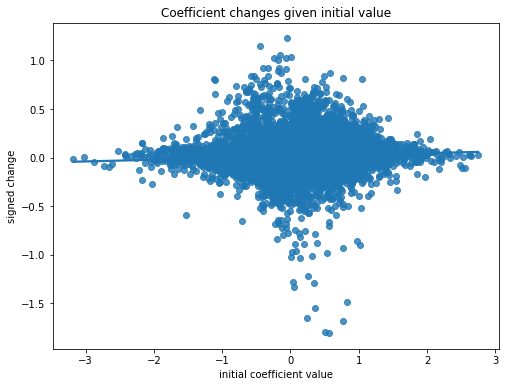

In [271]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(initial_weights, signed_changes, ax=ax)
ax.set_xlabel("initial coefficient value")
ax.set_ylabel("signed change")
ax.set_title("Coefficient changes given initial value")

plt.plot()

[]

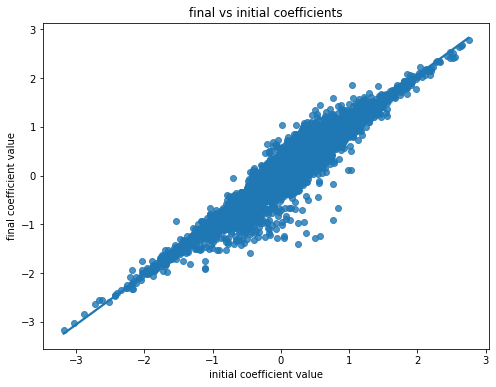

In [276]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(initial_weights, final_weights, ax=ax)
ax.set_xlabel("initial coefficient value")
ax.set_ylabel("final coefficient value")
ax.set_title("final vs initial coefficients")

plt.plot()

[]

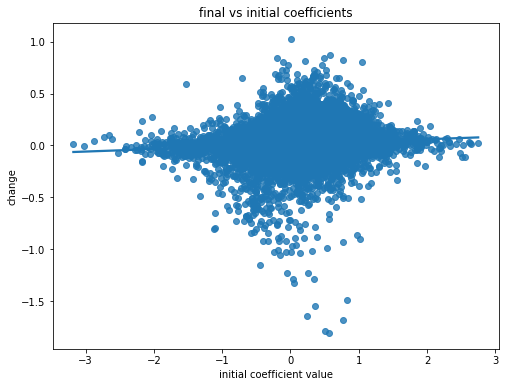

In [275]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(initial_weights, final_weights - initial_weights, ax=ax)
ax.set_xlabel("initial coefficient value")
ax.set_ylabel("change")
ax.set_title("final vs initial coefficients")

plt.plot()

## Distance between neural nets

Surely this has been thought about elsewhere, but before I go looking,
let's write up some thoughts about how to calculate the distance
between different neural networks in some metric space that we'll
describe below. We will start with the types of neural networks
that we have been consdering above: single ouput neural networks
where all non-constant neurons have the same activation function.

I'll talk about generalizing a little bit, but it's hard to say which
generalizations would be useful, and which would not be.

### Same architecture

To start, let's consider neural networks $N\_1$ and $N\_2$ which have
the same architecture: same output activation function, same input
dimensions, same number of layers, and same number of neurons in
each layer with the same (identical in this case) activation functions
for each neuron, and each layer correspondingly does or does not 
have bias neurons (i.e., a neuron which just puts out 1 and does not
take input). 

Let the layer $V\_{t, i}$ consist of the neurons 
$\{v\_{t, i}^1, \ldots, v\_{t, i}^{n\_t}\}$
each with the same activation function, as well as possibly having
a bias neuron $v^{n\_t+1}\_{t, i}$ which takes no input and always has 1
as its output. Let $W^{t, i}$ be the weight matrix from $V\_{t, i}$ 
to $V\_{t+1, i}$ for network $N\_i$. We make an identification
between neurons and weights in the natural way, i.e., the output of
$v^j\_{t, i}$ is weighted according to column $j$ of $W^{t, i}$
and the input of $v^k\_{t+1, i}$ is weighted according to row $k$
in $W^{t, i}$. 

A first attempt at defining the distance between $N_1$ and $N_2$
would be to embed all the weights into vectors then take say the
Euclidean distance between these two vectors.

#### Neuron permutations

However, note that element-wise the $W^{t, i}$ might be
distinct, but the outputs of the neural networks could be identical.
One way this is possible, is if the neurons in a given layer have been
re-ordered in some way. In other words, maybe all the weights
would be identical if we switched $v^1\_{t, 2}$ and $v^2\_{t, 2}$.
In terms of $W^{t, 2}$, this would mean switching column 1 and
column 2. We also need to simultaneously switch rows 1 and 2 of $W^{t-1, 2}$.
Note that we are only switching non-bias neurons in hidden layers
and two transformations will also have to happen.

If $W^{t, i}$ is an $n\_{t+1}\times n\_t$ matrix, then this
means multiplying on the right by an $n\_t \times n\_t$ matrix
which looks like the identity matrix except rows 1 and 2 have been
swapped. We multiply $W^{t-1, i}$ by the same matrix, but on the
left instead. More generally, we can replace the special matrix
above with any permutation matrix, that is, a square matrix with
a exactly a single 1 in each row and column. If $V^{t, i}$
has a bias neuron, we do not allow it to be permuted, instead
taking

Since these transformations do not change the output at all,
we should change the distance to be invariant under them.
We can do this by taking the distance to be the minimum distance
between the weight vectors allowing for these permutations.

#### Scaling the output

If we only want to consider raw output, we should probably stop
with the above. But if we are considering 0-1 classification with
the output neuron having a sigmoid activation function, we
probably should not, since $N_1$ and $N_2$ will agree on the classification
if we scale the input to the output neuron by a positive constant. 
In other words, we scale $W^{T, i}$ (which is just a row vector) 
by a positive constant.

Should we allos invariance under these things? I think no. First off,
if we are doing regression this will not be desirable. Second off,
given that we are mostly considering $\operatorname{ReLU}$ activations,
we could achieve the same affect by mutliplying $W^{T-1, i}$ by
the same positive constant, as this would scale. But then this means
we could do the same thing by multiplying $W^{T-2, i}$ by that
same constant instead! And so on and so forth. However, not only 
is this not possible in the general case (although maybe multiplying
by some other scaled version of the constant would work), we would be
changing the distribution of the coeffciients which we meticulously 
set. So we will not make our distance function invariant under any
sort of scaling, just permutation.

### Different architectures

As long as the activation functions are the same, you can pad out
shorter layers with neurons that always have zero input and zero
output until the architectures match. Basically, everything lives
in a space with infinitely many neurons at every layer with only
finitely many of the neurons nonzero.

I don't know that there is much that can be done if the activation
functions are different in a given layer. If there are matching
activation functions in each layer you could pair them off, but
this seems like a rare case.

### Implementation

I am not sure the best way to implement these distances. I think 
one way to go that won't necessarily guarantee you the true distance as
defined above would be to move layer by layer. The issue is that shifting
neurons in one layer affects two weight matrices simultaneously.
So perhaps you stop shifting when only the input weights to that layer
are closest. You could also stop when the distance is lowered overall 
which takes into account both input and output weight matrices, but
the output weight matrix will again be shifted when the next layer 
is perturbed. The drawback of the first method is that the final
layer of weight matrices are never directly compared. Neither of
these methods guarantees you find the true distance between the
neural nets.

For a given layer, I'm going to brute force it and check all possible
row combinations. Since my layers are not very wide (max of like 10)
this shouldn't take too long even for half a dozen layers.

I think that if the neural nets are identical save for neuron order
that we will get zero as the distance using this algorithm.

Aside: is there a way that architecturally identical neural networks
can have exactly the same decision boundary with distinct weights?
Possibly.

In [29]:
def matrix_dist(x, y):
    """ calculate ell^2 distance between x and y
    which are numpy arrays with the same shape """
    
    return np.mean(np.sqrt((x - y)*(x - y)))

def permute(n, k):
    """ get permutation on n elements where
    k between 1 and n! parametrizes the permutations """
    x = list(np.arange(n))
    p = []
    while len(x) > 0:
        ell = len(x)
        p += [x.pop(k % ell)]
        k = int((k - k % ell) / ell)

    return p

def factorial(n):
    return np.prod(np.arange(n)+1)

In [103]:
nn_1 = ReLUNet([8, 8, 4], random_seed=1)
nn_2 = ReLUNet([8, 8, 4], random_seed=2)

In [114]:
np.arange(1, 4)

array([1, 2, 3])

In [129]:
def approx_neural_net_dist(nn_1, nn_2):
    """ approximates the distance between the neural nets
    assuming that they have the same architecture """
    # these are deep copies now
    w_1 = nn_1.w
    w_2 = nn_2.w
    
    # re-arrange one hidden layer at a time
    for i in np.arange(1, len(nn_1.layers)-1):
        has_const = nn_1.layers[i].has_const
        
        if has_const:
            num_neurons = nn_1.layers[i].width - 1
        else:
            num_neurons = nn_1.layers[i].width
    
        min_dist = np.Infinity
        min_row_order = None

        for j in range(factorial(num_neurons)):

            if has_const:
                row_order = permute(num_neurons, j) + [num_neurons]
            else:
                row_order = permute(num_neurons, j)

            dist = matrix_dist(w_1[i-1], w_2[i-1][row_order])

            if dist < min_dist:
                min_dist = dist
                min_row_order = row_order

        w_2[i-1] = w_2[i-1][min_row_order].copy()
        w_2[i] = w_2[i][:, min_row_order].copy()
        
    w_1_flat = np.concatenate([ww.flatten() for ww in w_1])
    w_2_flat = np.concatenate([ww.flatten() for ww in w_2])
    
    return matrix_dist(w_1_flat, w_2_flat)